In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [15]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [16]:
lags = [2, 5, 6, 11, 12]
date_features = ["month", "year"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/monthly/"

In [17]:
def load_and_preprocess_daily_data(start_index, end_index, lags, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", index_type=index_type, freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[1], freq="M", index_type=index_type, start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    train_test_division = math.floor(0.2*len(df_date_features))
    data_train = df_date_features.iloc[:-train_test_division, :].copy()
    data_test = df_date_features.iloc[-train_test_division:, :].copy()

    return data_train, data_test

In [27]:
save_name="monthly.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

In [28]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
start_index="2014-01-01"
end_index="2023-03-31"

print(best_model_string)

GradientBoostingRegressor


### All predictors

In [20]:
data_train, data_test = load_and_preprocess_daily_data(start_index, end_index, lags=lags, date_features=date_features)

In [22]:
shap_values_prepandemic = func.predictors_influence_study(data_train, data_test, best_model)

Prediction MASE: 11.702785531564665


Permutation explainer: 20it [00:11,  1.18it/s]                        


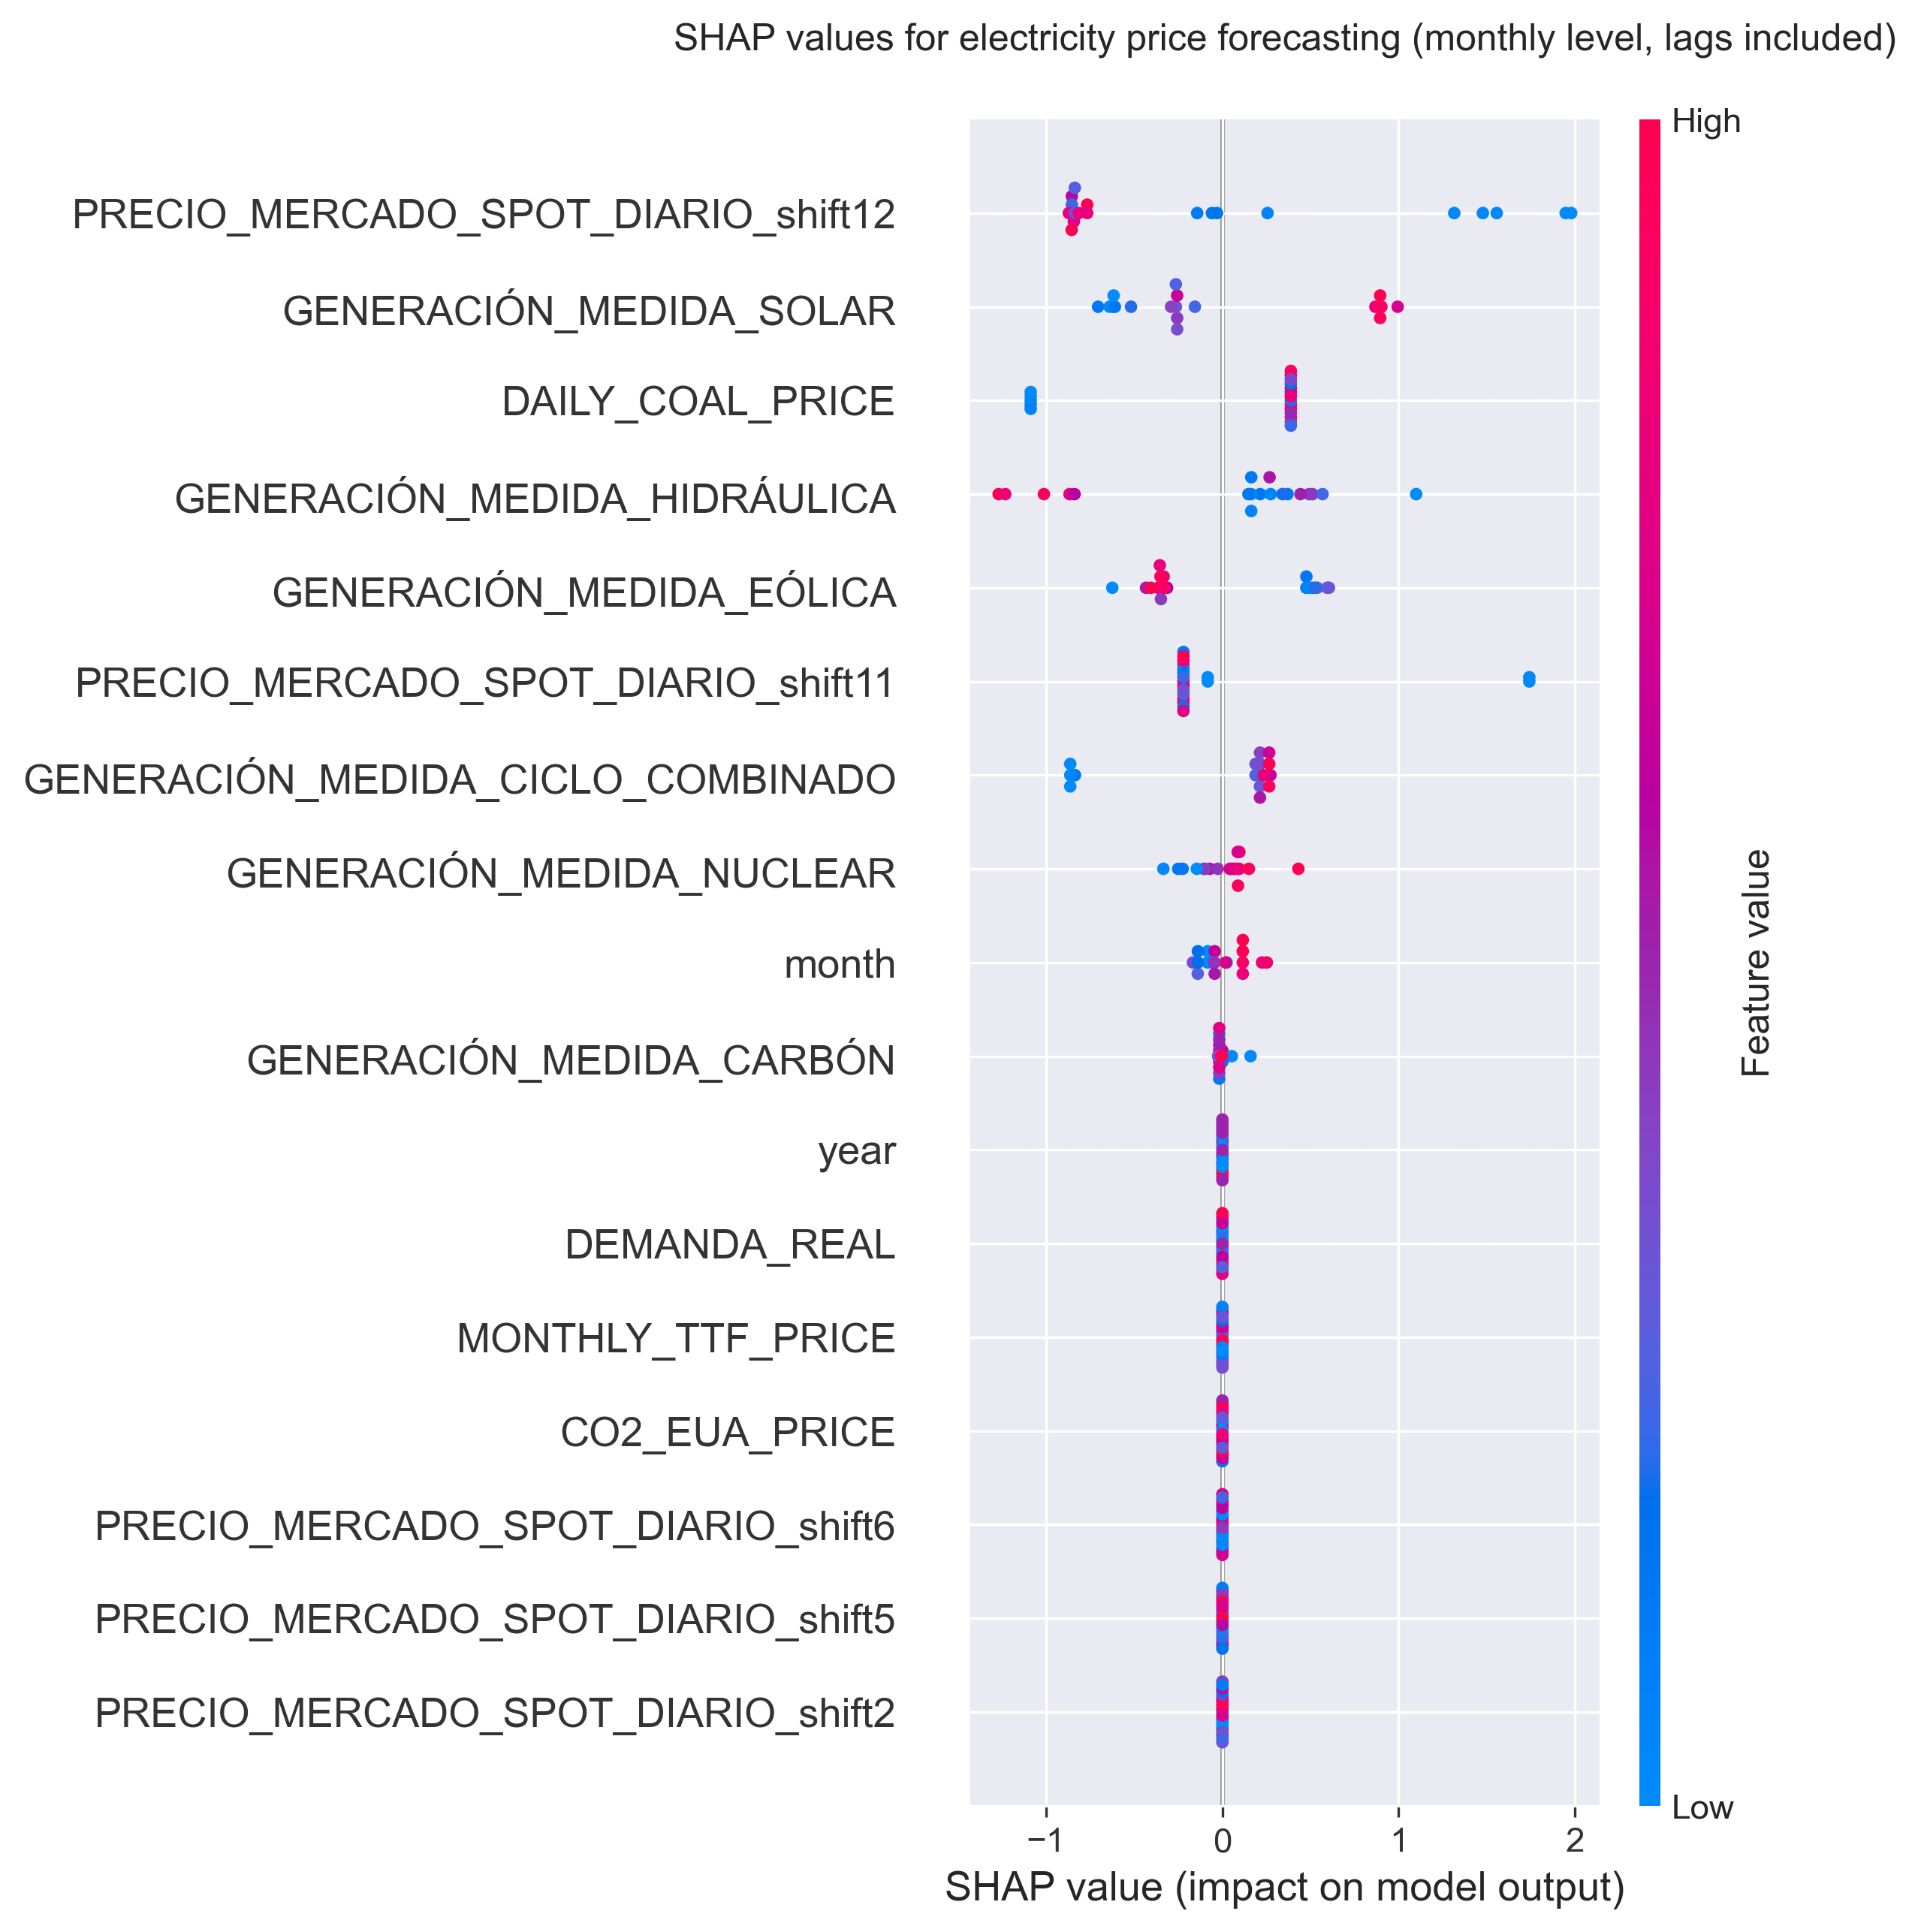

In [23]:
shap.summary_plot(shap_values_prepandemic, show=False)
plt.title("SHAP values for electricity price forecasting (monthly level, lags included)", y=1.03)
plt.show()

### No lags

In [24]:
data_train, data_test = load_and_preprocess_daily_data(start_index, end_index, lags=[], date_features=date_features)

In [25]:
shap_values_nolags_prepandemic = func.predictors_influence_study(data_train, data_test, best_model)

Prediction MASE: 14.916510984702184


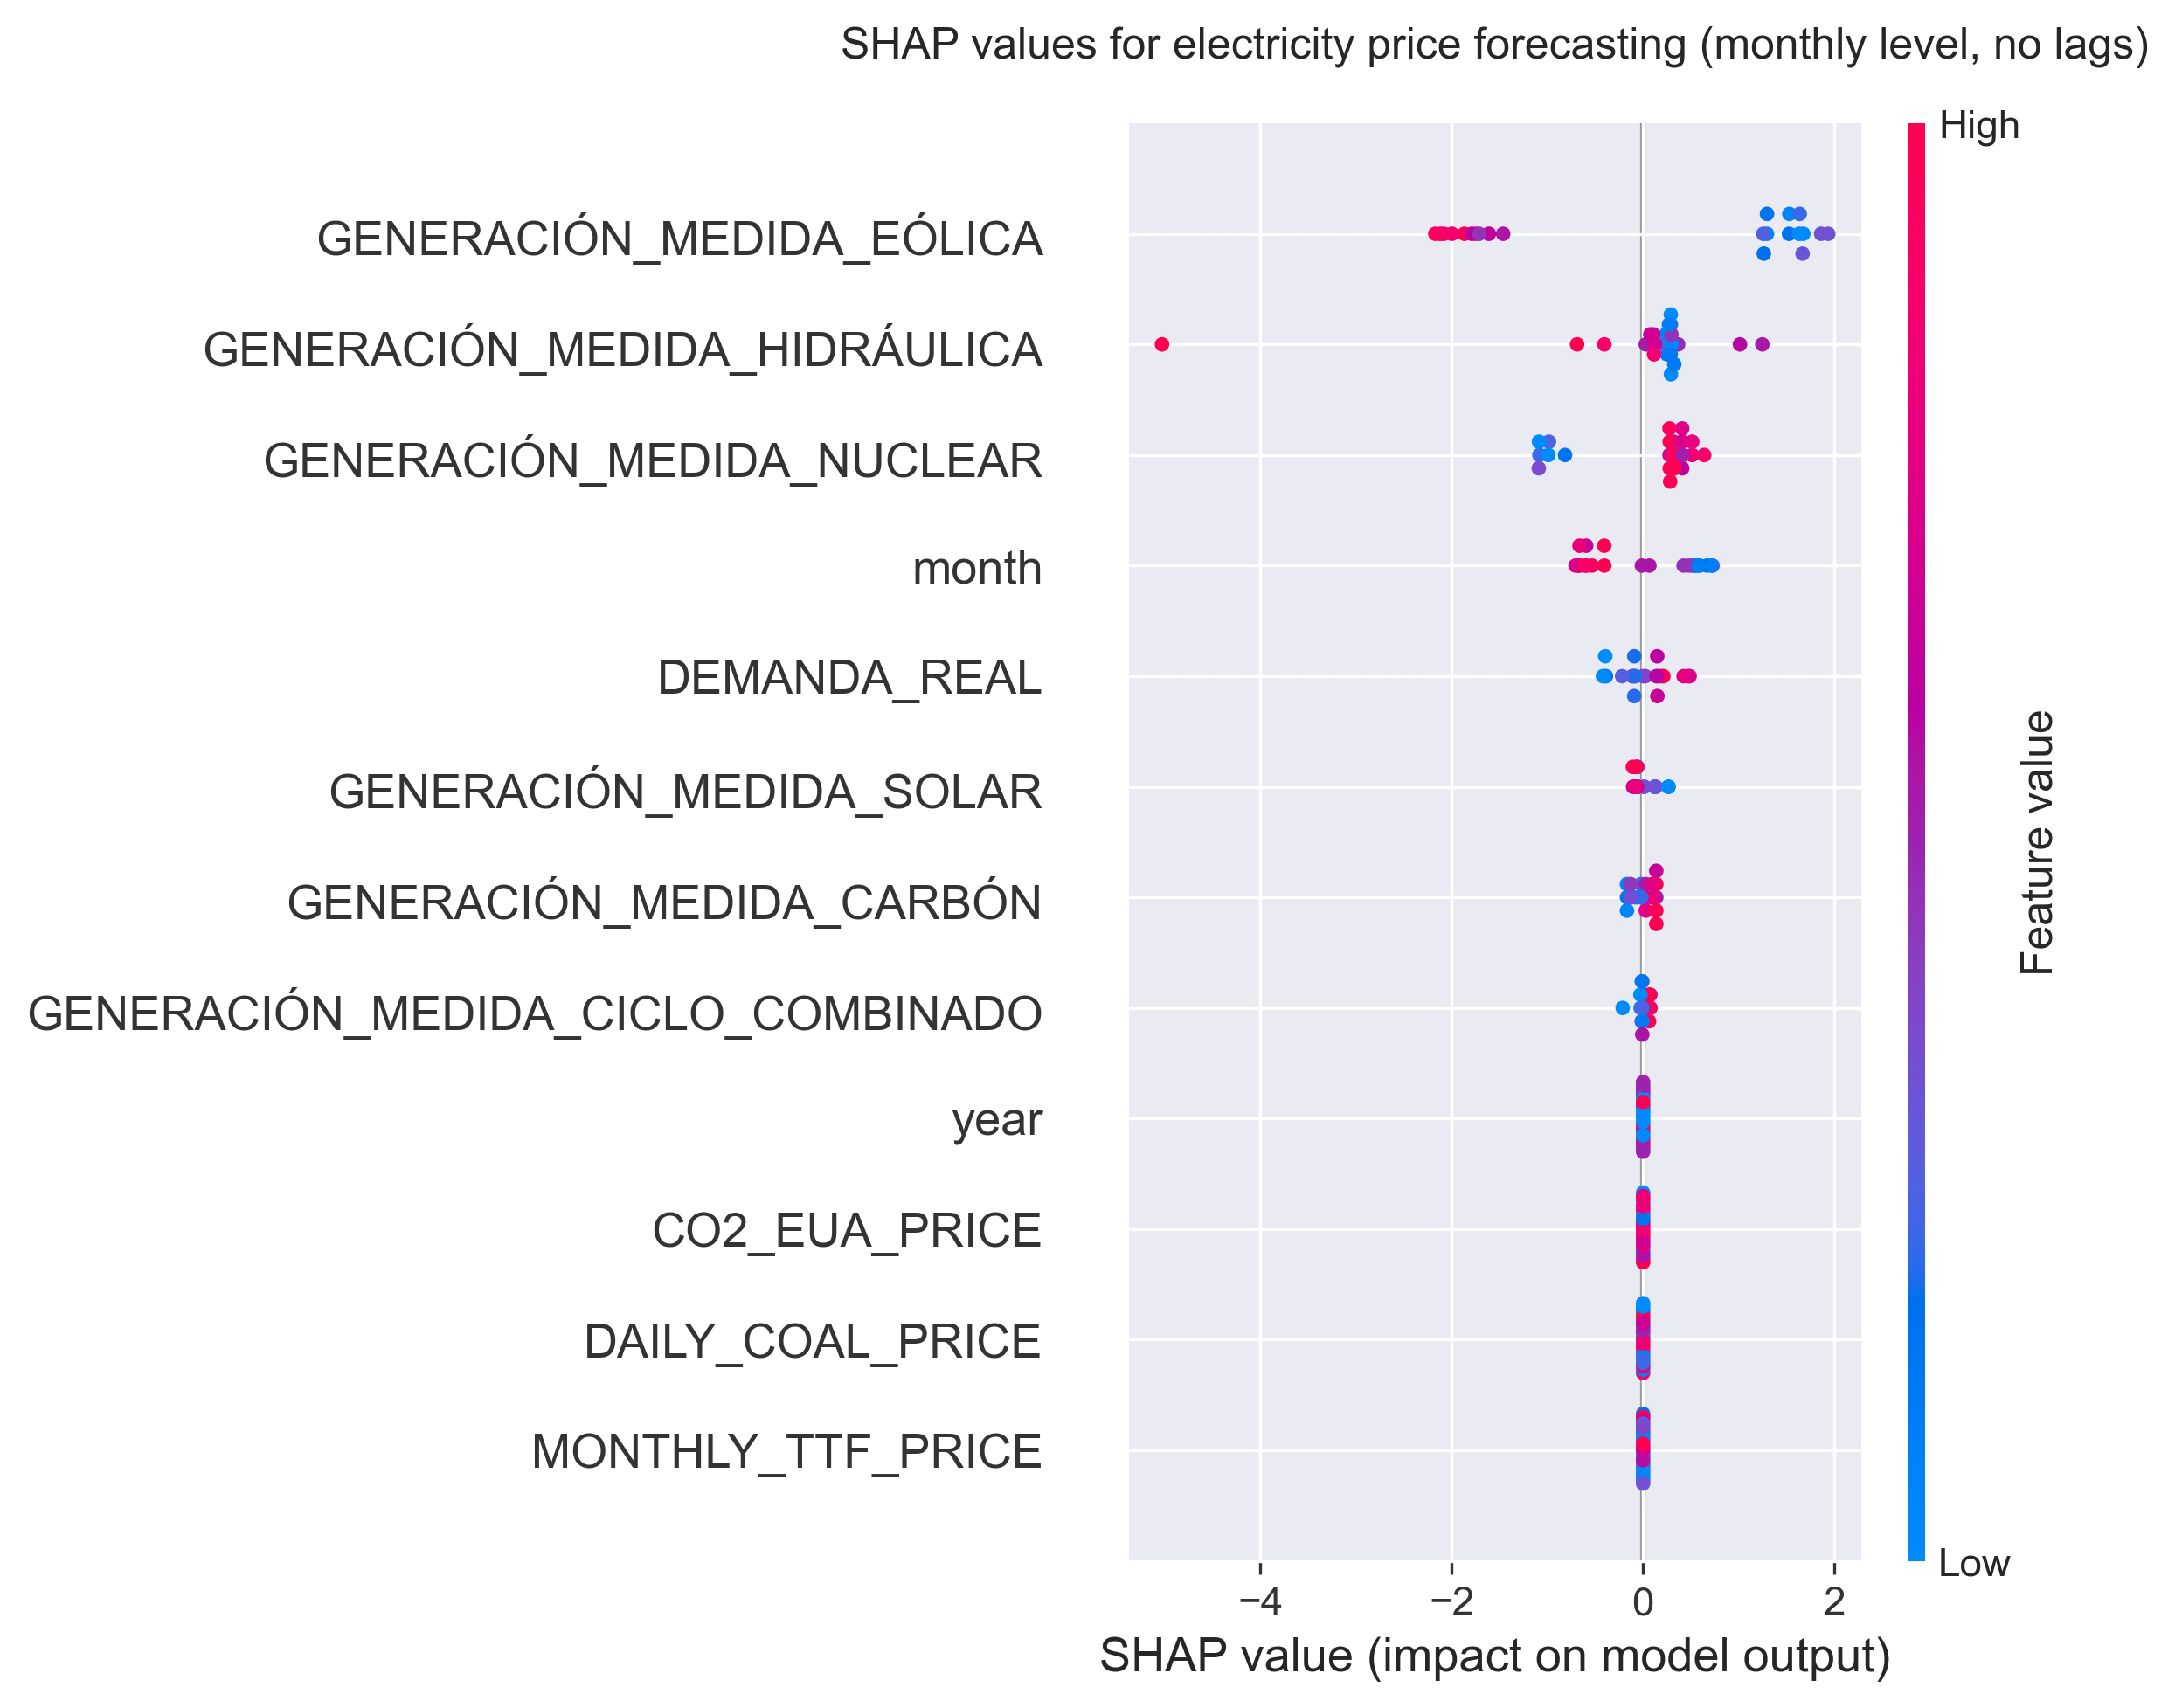

In [26]:
shap.summary_plot(shap_values_nolags_prepandemic, show=False)
plt.title(f"SHAP values for electricity price forecasting (monthly level, no lags)", y=1.03)
plt.show()